In [646]:
import os
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, lognorm, pearsonr
import wikipediaapi
import re
from difflib import get_close_matches
from sklearn.feature_extraction.text import TfidfVectorizer
import faiss
import numpy as np
from sklearn.linear_model import LinearRegression


In [647]:
# Define a custom user-agent string
USER_AGENT = "GlobalEcoMidtermProject/1.0 (Contact: mp7179@nyu.edu) Python-requests"

# Initialize the Wikipedia API with the custom User-Agent
wiki_wiki = wikipediaapi.Wikipedia(
    language='en',
    extract_format=wikipediaapi.ExtractFormat.WIKI,
    user_agent=USER_AGENT
)


def search_wikipedia(refinery_name):
    # Search for the page with the refinery name
    page = wiki_wiki.page(refinery_name)
    
    # Check if the page exists
    if not page.exists():
        print(f"No Wikipedia page found for {refinery_name}")
        return None
    
    # Print page summary
    print(f"Summary for {refinery_name}:")
    print(page.summary)
    
    # Search for relevant production information (e.g., barrels per year)
    keywords = ["barrels per year", "barrels per day", "bpd", "production capacity"]
    for section in page.sections:
        for keyword in keywords:
            if keyword.lower() in section.text.lower():
                print(f"Production info found: {section.text}")
                break

def get_wiki_text(page_title):
    """
    Fetch the summary of a Wikipedia page using the Wikipedia API.
    
    :param page_title: Title of the Wikipedia page.
    :return: Text content of the Wikipedia page.
    """
    page = wiki_wiki.page(page_title)
    if page.exists():
        return page.text
    else:
        return None

def replace_value_in_dataframe(df, name_key, replace_value):
    """
    Function to replace the value in the 'Name' column of the dataframe.

    :param df: The pandas dataframe to update
    :param name_key: The value in the 'Name' column to search for
    :param replace_value: The new value to replace the matching 'Name'
    :return: Updated dataframe with the replaced value
    """
    # Check if the 'Name' column contains the name_key
    if name_key in df['Name'].values:
        # Find the row with the matching 'Name' and replace it
        df.loc[df['Name'] == name_key, 'Name'] = replace_value
        print(f"Replaced '{name_key}' with '{replace_value}' in the 'Name' column.")
    else:
        print(f"'{name_key}' not found in the 'Name' column.")
    
    return df

def update_refinery_name(refinery_list, current_name, new_name):
    """
    Function to update the name of a refinery in a list of dictionaries.
    
    :param refinery_list: List of dictionaries containing refinery data
    :param current_name: The current name of the refinery to search for
    :param new_name: The new name to update the refinery with
    :return: None (updates the list in place)
    """
    # Loop through the refinery list
    for refinery in refinery_list:
        # Check if the current name matches the refinery name
        if current_name.lower() in refinery['Refinery'].lower():
            # Update the refinery name with the new name
            refinery['Refinery'] = new_name
            print(f"Updated refinery name from {current_name} to {new_name}")
            return  # Exit once the refinery is found and updated
    
    print(f"Refinery {current_name} not found.")



In [648]:
# Replace with your actual Climate TRACE API key
BASE_URL = 'https://api.climatetrace.org/v4/assets'  # Climate TRACE API base URL

# Headers for the API request
headers = {
    'Content-Type': 'application/json',
}
params = {
    'sort_by': 'emissions',  # Sort assets by emissions
    'order': 'desc',         # Sort in descending order (highest first)
    'limit': 4000           # Number of assets to return
}

# Make the GET request to the Climate TRACE API
response = requests.get(BASE_URL, headers=headers, params=params)
rj = response.json()

In [649]:
# Replace with your actual Climate TRACE API key
BASE_URL = 'https://api.climatetrace.org/v4/assets'  # Climate TRACE API base URL

# Headers for the API request
headers = {
    'Content-Type': 'application/json',
}
params = {
    'sort_by': 'emissions',  # Sort assets by emissions
    'order': 'desc',         # Sort in descending order (highest first)
    'limit': 4000,           # Number of assets to return
    'subsectors': 'oil-and-gas-refining'
}

# Make the GET request to the Climate TRACE API
response = requests.get(BASE_URL, headers=headers, params=params)
oil_rj = response.json()

In [650]:
def json_to_dataframe(json_data):
    # Prepare an empty list to store rows
    rows = []

    # Loop through each asset in the JSON
    for asset in json_data['assets']:
        for year_data in asset['Emissions']:
            for year, emissions_list in year_data.items():
                # Create a dictionary to hold the combined emissions data for each year
                row = {
                    'Id': asset['Id'],
                    'Name': asset['Name'],
                    'Country': asset['Country'],
                    'Sector': asset['Sector'],
                    'AssetType': asset['AssetType'],
                    'Year': year,
                    'CO2 Emissions (tonnes)': None,
                    'CH4 Emissions (tonnes)': None,
                    'CO2e 20yr (tonnes)': None,
                    'CO2e 100yr (tonnes)': None,
                    'Owners': None  # New field for owners
                }

                # Extract the owners
                if asset.get('Owners'):
                    # Collect owner names
                    owner_names = [owner['CompanyName'] for owner in asset['Owners']]
                    # Join all owner names into a single string
                    row['Owners'] = ', '.join(owner_names)

                # Loop through each emission type and fill in the respective values in the row
                for emissions_data in emissions_list:
                    if 'co2' in emissions_data:
                        row['CO2 Emissions (tonnes)'] = emissions_data['co2']
                    if 'ch4' in emissions_data:
                        row['CH4 Emissions (tonnes)'] = emissions_data['ch4']
                    if 'co2e_20yr' in emissions_data:
                        row['CO2e 20yr (tonnes)'] = emissions_data['co2e_20yr']
                    if 'co2e_100yr' in emissions_data:
                        row['CO2e 100yr (tonnes)'] = emissions_data['co2e_100yr']

                # Append the row to the list
                rows.append(row)

    # Convert the list of rows into a DataFrame
    df = pd.DataFrame(rows)

    return df

In [651]:
df = json_to_dataframe(rj)
df = df[df['Year'] == '2022']
df = df.dropna(subset=['CO2 Emissions (tonnes)'])

In [652]:
oil_ref_df = json_to_dataframe(oil_rj)
oil_ref_df = oil_ref_df[oil_ref_df['Year'] == '2022']
oil_ref_df = oil_ref_df[oil_ref_df['CO2 Emissions (tonnes)'] > 0]
#manually adjust some refinery names
oil_ref_df = replace_value_in_dataframe(oil_ref_df, 'Khabrovsk Refinery', 'Khabarovsk Refinery')
oil_ref_df = replace_value_in_dataframe(oil_ref_df, 'Turkmen Petroleum Seydi Refinery', 'Seidi')
oil_ref_df = replace_value_in_dataframe(oil_ref_df, 'Bayernoil Neustadt Refinery', 'Ingolstadt Refinery (Bayernoil(VARO/Eni/Rosneft/BP))')
oil_ref_df = replace_value_in_dataframe(oil_ref_df, 'Nynas Petroleum Nynashamn Refinery', 'Nynäshamn Refinery')

Replaced 'Khabrovsk Refinery' with 'Khabarovsk Refinery' in the 'Name' column.
Replaced 'Turkmen Petroleum Seydi Refinery' with 'Seidi' in the 'Name' column.
Replaced 'Bayernoil Neustadt Refinery' with 'Ingolstadt Refinery (Bayernoil(VARO/Eni/Rosneft/BP))' in the 'Name' column.
Replaced 'Nynas Petroleum Nynashamn Refinery' with 'Nynäshamn Refinery' in the 'Name' column.


In [653]:
text = get_wiki_text("List_of_oil_refineries").split("\nWorld\'s largest refineries\n")[1].split("See also")
text = text[0]

In [654]:

# Define a flexible regex pattern to capture refinery details
# This pattern captures everything before the barrels per day in the refinery name
pattern = re.compile(
    r'(?P<refinery>.+?)\s*(?:\(|,|\s)\s*(?P<capacity>([\d,]+)\s*bbl(?:/d|/day|))', re.IGNORECASE)

# Extract refinery details using regex
matches = pattern.findall(text)

# Structure the extracted data
refinery_data = []

for match in matches:
    refinery, capacity, numeric_capacity = match
    
    # Clean refinery name by removing extra text after parentheses or commas
    refinery_cleaned = refinery.strip()
    
    # Convert capacity to integer (removing commas)
    try:
        capacity_cleaned = int(numeric_capacity.replace(',', ''))
    except ValueError:
        capacity_cleaned = None  # Handle case where conversion is not possible
    
    refinery_data.append({
        "Refinery": refinery_cleaned,
        "Capacity (bbl/day)": capacity_cleaned
    })

# Filter out entries without valid refinery names
refinery_data = [rd for rd in refinery_data if rd['Refinery']]

In [655]:
update_refinery_name(refinery_data, 'Puerto Limón Refinery (Recope) (start-up 1967), not operational since 2011', 'Puerta Limon Refinery')
update_refinery_name(refinery_data, 'Odesa Refinery (LUKOIL)', 'Vetek Odessa Refinery')
update_refinery_name(refinery_data, 'Clarkson Refinery, Mississauga, Ontario (HollyFrontier)', 'Petro-Canada Mississauga Lubricants Refinery')

# Chinese refineries that don't turn up anywhere
update_refinery_name(refinery_data, 'Fushun Petrochemical Refinery, Fushun Petrochemical Company (CNPC)', 'PetroChina Liaoning Liaohe Panjin Refinery')


Updated refinery name from Puerto Limón Refinery (Recope) (start-up 1967), not operational since 2011 to Puerta Limon Refinery
Updated refinery name from Odesa Refinery (LUKOIL) to Vetek Odessa Refinery
Updated refinery name from Clarkson Refinery, Mississauga, Ontario (HollyFrontier) to Petro-Canada Mississauga Lubricants Refinery
Updated refinery name from Fushun Petrochemical Refinery, Fushun Petrochemical Company (CNPC) to PetroChina Liaoning Liaohe Panjin Refinery


In [656]:
# List of irrelevant terms for FAISS matching (specific industry terms)
irrelevant_terms = ['oil', 'petrochemical', 'refining', 'refinery', '(tüpraş)', 'star', 'company', 'limited', 'group', 'energy', 'petroleum', 'co', 'lp', 'abu', 'dhabi', 'eastern', 'singapore', 'sibneft', 'agoco', 'nprc']

# Additional irrelevant terms for word-by-word fallback matching (general terms)
fallback_irrelevant_terms = ['petrochemical', 'refining', 'oil', 'refinery', 'the', 'corporation', 'asphalt']

# 1. Preprocess Refinery Names: Remove common words, lower case, and normalize
def preprocess_name(name, fallback=False):
    name = name.lower()  # Lowercase
    terms_to_remove = fallback_irrelevant_terms if fallback else irrelevant_terms  # Use the fallback list if necessary
    for term in terms_to_remove:
        name = re.sub(rf'\b{term}\b', '', name)
    name = re.sub(r'\s+', ' ', name).strip()  # Remove extra spaces
    return name

# Apply preprocessing to refinery names and oil_ref_df names
preprocessed_refinery_names = [preprocess_name(ref['Refinery']) for ref in refinery_data]
oil_ref_df['Preprocessed Name'] = oil_ref_df['Name'].apply(preprocess_name)

# 2. Convert Preprocessed Refinery Names to TF-IDF embeddings
vectorizer = TfidfVectorizer(stop_words='english')
refinery_embeddings = vectorizer.fit_transform(preprocessed_refinery_names).toarray()

# 3. Initialize FAISS index for cosine similarity search
vector_dim = refinery_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(vector_dim)  # Using L2 distance (Euclidean)

# 4. Add the TF-IDF embeddings to the FAISS index
faiss_index.add(refinery_embeddings.astype(np.float32))

# 5. Function to find the nearest refinery using FAISS index
def get_nearest_refinery(preprocessed_name, original_name):
    # Convert the query refinery name into the same TF-IDF vector space
    query_vector = vectorizer.transform([preprocessed_name]).toarray().astype(np.float32)
    
    # Search for the nearest neighbor using FAISS
    distances, indices = faiss_index.search(query_vector, 1)
    
    # Retrieve the best match name and corresponding capacity from FAISS results
    if indices[0][0] != -1:
        best_match_name = refinery_data[indices[0][0]]['Refinery']
        if distances[0][0] < 0.7:  # Adjust the threshold for FAISS matches
            return refinery_data[indices[0][0]]['Capacity (bbl/day)'], best_match_name
    
    # Fallback: Perform a word-by-word search if FAISS doesn't give a good match
    query_words = set(preprocessed_name.split())
    
    # Search for matches in the refinery_data using word-by-word comparison
    for refinery in refinery_data:
        refinery_words = set(preprocess_name(refinery['Refinery'], fallback=True).split())
        if query_words & refinery_words:  # If at least one word matches
            return refinery['Capacity (bbl/day)'], refinery['Refinery']
    
    return None, None  # If no match is found

# 6. Apply the matching function to the oil_ref_df DataFrame
def apply_matching(row):
    capacity, matched_refinery = get_nearest_refinery(row['Preprocessed Name'], row['Name'])
    return pd.Series([capacity, matched_refinery])

# Apply the function to match refineries and get their capacities
oil_ref_df[['Barrels per Day', 'Matched Refinery Name']] = oil_ref_df.apply(apply_matching, axis=1)

In [657]:
# Filter rows where 'Barrels per Day' is NaN or 0
dropped = oil_ref_df[(oil_ref_df['Barrels per Day'].isna()) | (oil_ref_df['Barrels per Day'] == 0)]

# Drop rows from the original DataFrame where 'Barrels per Day' is NaN or 0
oil_ref_df = oil_ref_df.dropna(subset=['Barrels per Day'])
oil_ref_df = oil_ref_df[oil_ref_df['Barrels per Day'] != 0]



In [658]:
# Define the new rows (hardcoded examples)
new_rows = [
    {
        'Id': 3143817,
        'Name': 'ZPC Zhejiang Rongsheng Refinery',
        'Country': 'CHN',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Deep Conversion',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 9453210.878,
        'CH4 Emissions (tonnes)': 426.5121851,
        'CO2e 20yr (tonnes)': 9548062.088,
        'CO2e 100yr (tonnes)': 9547156.432,
        'Owners': 'Rongsheng',
        'Preprocessed Name': 'zpc zhejiang rongsheng refinery',
        'Barrels per Day': 800000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3143820,
        'Name': 'CNOOC Huizhou Refinery',
        'Country': 'CHN',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Deep Conversion',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 5199265.983,
        'CH4 Emissions (tonnes)': 234.5817018,
        'CO2e 20yr (tonnes)': 5251434.148,
        'CO2e 100yr (tonnes)': 5250936.037,
        'Owners': 'CNOOC',
        'Preprocessed Name': 'cnooc huizhou refinery',
        'Barrels per Day': 240000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3143832,
        'Name': 'CNOOC Zhejiang Ningbo Daxie Zhoushan Refinery',
        'Country': 'CHN',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Deep Conversion',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 4726605.439,
        'CH4 Emissions (tonnes)': 213.2560926,
        'CO2e 20yr (tonnes)': 4774031.044,
        'CO2e 100yr (tonnes)': 4773578.216,
        'Owners': 'CNOOC',
        'Preprocessed Name': 'cnooc zhejiang ningbo daxie zhoushan refinery',
        'Barrels per Day': 400000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3144167,
        'Name': 'Alty-Arik Refinery',
        'Country': 'UZB',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Hydroskimming',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 84407.86747,
        'CH4 Emissions (tonnes)': 13.93440811,
        'CO2e 20yr (tonnes)': 87030.35412,
        'CO2e 100yr (tonnes)': 87029.95704,
        'Owners': 'Uzbekneftegaz',
        'Preprocessed Name': 'alty-arik refinery',
        'Barrels per Day': 66000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3144010,
        'Name': 'NOC Zawia Refinery',
        'Country': 'LBY',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Hydroskimming',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 415614.9865,
        'CH4 Emissions (tonnes)': 62.78131719,
        'CO2e 20yr (tonnes)': 427393.6004,
        'CO2e 100yr (tonnes)': 427391.9003,
        'Owners': 'National Oil',
        'Preprocessed Name': 'noc zawia refinery',
        'Barrels per Day': 120000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3144166,
        'Name': 'Bukhara Refinery',
        'Country': 'UZB',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Hydroskimming',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 63945.35414,
        'CH4 Emissions (tonnes)': 10.55636978,
        'CO2e 20yr (tonnes)': 65932.08646,
        'CO2e 100yr (tonnes)': 65931.78564,
        'Owners': 'Uzbekneftegaz',
        'Preprocessed Name': 'bukhara refinery',
        'Barrels per Day': 50000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3144151,
        'Name': 'Ukrtransneft Drogobych Refinery',
        'Country': 'UKR',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Hydroskimming',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 59248.65642,
        'CH4 Emissions (tonnes)': 8.762803852,
        'CO2e 20yr (tonnes)': 60915.13452,
        'CO2e 100yr (tonnes)': 60914.87111,
        'Owners': 'Ukrtransneft',
        'Preprocessed Name': 'ukrtransneft drogobych refinery',
        'Barrels per Day': 70000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3143762,
        'Name': 'BSP Brunei Refinery',
        'Country': 'BRN',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Hydroskimming',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 37538.59991,
        'CH4 Emissions (tonnes)': 5.777141509,
        'CO2e 20yr (tonnes)': 38631.91977,
        'CO2e 100yr (tonnes)': 38631.7506,
        'Owners': 'Brunei Shell Petroleum',
        'Preprocessed Name': 'bsp brunei refinery',
        'Barrels per Day': 10000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3143933,
        'Name': 'IOC Digboi Refinery',
        'Country': 'IND',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Deep Conversion',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 189452.9154,
        'CH4 Emissions (tonnes)': 8.685684502,
        'CO2e 20yr (tonnes)': 191382.0359,
        'CO2e 100yr (tonnes)': 191363.6231,
        'Owners': 'IndianOil',
        'Preprocessed Name': 'ioc digboi refinery',
        'Barrels per Day': 13000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3143932,
        'Name': 'IOC Guwahati Refinery',
        'Country': 'IND',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Deep Conversion',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 291466.0236,
        'CH4 Emissions (tonnes)': 13.36259154,
        'CO2e 20yr (tonnes)': 294433.9014,
        'CO2e 100yr (tonnes)': 294405.574,
        'Owners': 'IndianOil',
        'Preprocessed Name': 'ioc guwahati refinery',
        'Barrels per Day': 20000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3144138,
        'Name': 'Star Petroleum Map Ta Phut Refinery',
        'Country': 'THA',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Medium Conversion',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 1600056.213,
        'CH4 Emissions (tonnes)': 79.78030956,
        'CO2e 20yr (tonnes)': 1617804.439,
        'CO2e 100yr (tonnes)': 1617789.684,
        'Owners': 'Star Petroleum',
        'Preprocessed Name': 'map ta phut refinery',
        'Barrels per Day': 175000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3143925,
        'Name': 'Bharat Oman Refinery',
        'Country': 'IND',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Deep Conversion',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 1748796.142,
        'CH4 Emissions (tonnes)': 80.17554925,
        'CO2e 20yr (tonnes)': 1766603.409,
        'CO2e 100yr (tonnes)': 1766433.444,
        'Owners': 'Bharat Petroleum',
        'Preprocessed Name': 'bharat oman refinery',
        'Barrels per Day': 156000.0,
        'Matched Refinery Name': None
    },
    {
        'Id': 3143929,
        'Name': 'BPCL Numaligarh Refinery Ltd (NRL)',
        'Country': 'IND',
        'Sector': 'oil-and-gas-refining',
        'AssetType': 'Deep Conversion',
        'Year': 2022,
        'CO2 Emissions (tonnes)': 874398.0709,
        'CH4 Emissions (tonnes)': 40.08777463,
        'CO2e 20yr (tonnes)': 883301.7043,
        'CO2e 100yr (tonnes)': 883216.7221,
        'Owners': 'Oil India',
        'Preprocessed Name': 'bpcl numaligarh refinery ltd (nrl)',
        'Barrels per Day': 60000.0,
        'Matched Refinery Name': None
    }
]

# Convert new_rows to a DataFrame and concatenate with the existing DataFrame
new_df = pd.DataFrame(new_rows)
oil_ref_df = pd.concat([oil_ref_df, new_df], ignore_index=True)


In [659]:
# Convert Barrels per Day (BPD) to Barrels per Year
oil_ref_df['Barrels per Year'] = oil_ref_df['Barrels per Day'] * 200

# Calculate CO2 emissions per barrel on an annual basis
oil_ref_df['CO2_per_bbl_year'] = oil_ref_df['CO2 Emissions (tonnes)'] / oil_ref_df['Barrels per Year']
oil_ref_df['CO2_per_bbl_year'] = oil_ref_df['CH4 Emissions (tonnes)'] / oil_ref_df['Barrels per Year']

# Define the GWP for CH4 (using 34 as a default value for 100-year GWP)
GWP_CH4 = 34

# Calculate CH4 in CO2e (tonnes)
oil_ref_df['CH4_in_CO2e'] = oil_ref_df['CH4 Emissions (tonnes)'] * GWP_CH4

# Calculate Total CO2e emissions by adding CO2 emissions and CH4 in CO2e
oil_ref_df['Total_CO2e'] = oil_ref_df['CO2 Emissions (tonnes)'] + oil_ref_df['CH4_in_CO2e']

# Calculate pollution per barrel (Total CO2e divided by barrels per year)
oil_ref_df['Pollution_per_barrel'] = oil_ref_df['Total_CO2e'] / oil_ref_df['Barrels per Year']
oil_ref_df.to_csv('oil_ref_df.csv', index=False)
oil_ref_df

,Id,Name,Country,Sector,AssetType,Year,CO2 Emissions (tonnes),CH4 Emissions (tonnes),CO2e 20yr (tonnes),CO2e 100yr (tonnes),Owners,Preprocessed Name,Barrels per Day,Matched Refinery Name,Barrels per Year,CO2_per_bbl_year,CH4_in_CO2e,Total_CO2e,Pollution_per_barrel
0,3143912,RPL (Reliance Petroleum Limited) Jamnagar Refi...,IND,oil-and-gas-refining,Deep Conversion,2022,3.206126e+07,1469.885070,3.238773e+07,3.238461e+07,Reliance,rpl (reliance ) jamnagar,2200000.0,"Jamnagar Refinery (Reliance Industries), world...",440000000.0,0.000003,49976.092380,3.211124e+07,0.072980
1,3143817,ZPC Zhejiang Rongsheng Refinery,CHN,oil-and-gas-refining,Deep Conversion,2022,9.453211e+06,426.512185,9.548062e+06,9.547156e+06,Rongsheng,zpc zhejiang rongsheng,85000.0,Abu Dhabi Refinery (Abu Dhabi Oil Refining Com...,17000000.0,0.000025,14501.414293,9.467712e+06,0.556924
2,3144000,SK Corp Ulsan Refinery,KOR,oil-and-gas-refining,Medium Conversion,2022,8.118791e+06,408.233623,8.209572e+06,8.209497e+06,SK Energy,sk corp ulsan,850000.0,"SK Energy Co., Ltd. Ulsan Refinery (SK Energy)",170000000.0,0.000002,13879.943172,8.132671e+06,0.047839
3,3144154,Abu Dhabi Oil Refining Company Al-Ruwais Refinery,ARE,oil-and-gas-refining,Medium Conversion,2022,6.892611e+06,360.180723,6.972765e+06,6.972698e+06,ADNOC,al-ruwais,817000.0,Ruwais Refinery (Abu Dhabi Oil Refining Company),163400000.0,0.000002,12246.144589,6.904857e+06,0.042257
4,3143585,Marathon Petroleum Co LP Galveston Bay,USA,oil-and-gas-refining,Deep Conversion,2022,6.799479e+06,645.160674,6.895647e+06,6.843250e+06,Marathon Petroleum,marathon galveston bay,631000.0,"Galveston Bay Refinery (Marathon Petroleum), T...",126200000.0,0.000005,21935.462906,6.821414e+06,0.054052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,3143933,IOC Digboi Refinery,IND,oil-and-gas-refining,Deep Conversion,2022,1.894529e+05,8.685685,1.913820e+05,1.913636e+05,IndianOil,ioc digboi refinery,13000.0,None,2600000.0,0.000003,295.313273,1.897482e+05,0.072980
665,3143932,IOC Guwahati Refinery,IND,oil-and-gas-refining,Deep Conversion,2022,2.914660e+05,13.362592,2.944339e+05,2.944056e+05,IndianOil,ioc guwahati refinery,20000.0,None,4000000.0,0.000003,454.328112,2.919204e+05,0.072980
666,3144138,Star Petroleum Map Ta Phut Refinery,THA,oil-and-gas-refining,Medium Conversion,2022,1.600056e+06,79.780310,1.617804e+06,1.617790e+06,Star Petroleum,map ta phut refinery,175000.0,None,35000000.0,0.000002,2712.530525,1.602769e+06,0.045793
667,3143925,Bharat Oman Refinery,IND,oil-and-gas-refining,Deep Conversion,2022,1.748796e+06,80.175549,1.766603e+06,1.766433e+06,Bharat Petroleum,bharat oman refinery,156000.0,None,31200000.0,0.000003,2725.968674,1.751522e+06,0.056139


In [660]:
oil_ref_df['Pollution_per_barrel'].describe()

count    669.000000
mean       0.063633
std        0.277369
min        0.000489
25%        0.026077
50%        0.042417
75%        0.059173
max        6.977730
Name: Pollution_per_barrel, dtype: float64

In [661]:
oil_ref_df['CO2 Emissions (tonnes)'].describe()

count    6.690000e+02
mean     1.461214e+06
std      1.848001e+06
min      1.285313e+04
25%      3.631022e+05
50%      1.014461e+06
75%      1.948999e+06
max      3.206126e+07
Name: CO2 Emissions (tonnes), dtype: float64

In [662]:
oil_ref_df['Barrels per Day'].describe()

count    6.690000e+02
mean     1.540101e+05
std      1.482159e+05
min      1.600000e+03
25%      8.500000e+04
50%      1.140000e+05
75%      1.950000e+05
max      2.200000e+06
Name: Barrels per Day, dtype: float64

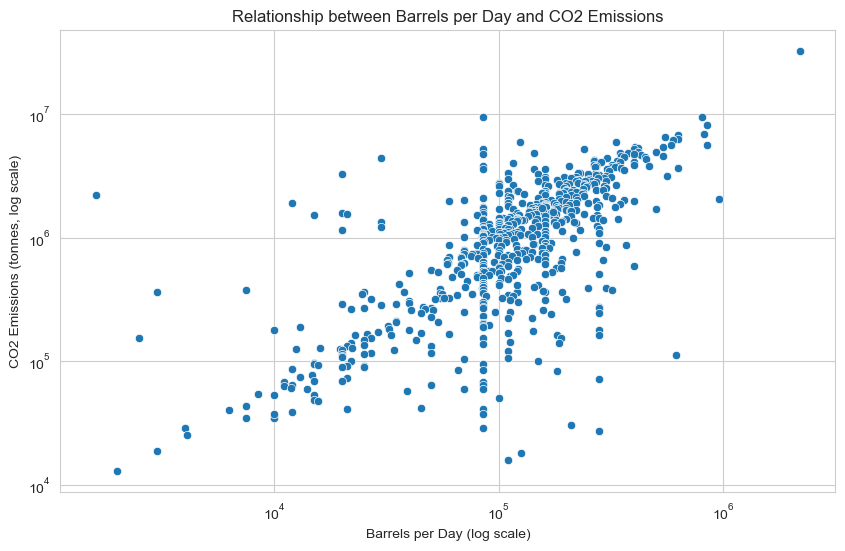

Pearson Correlation: 0.80
P-value: 1.40e-149


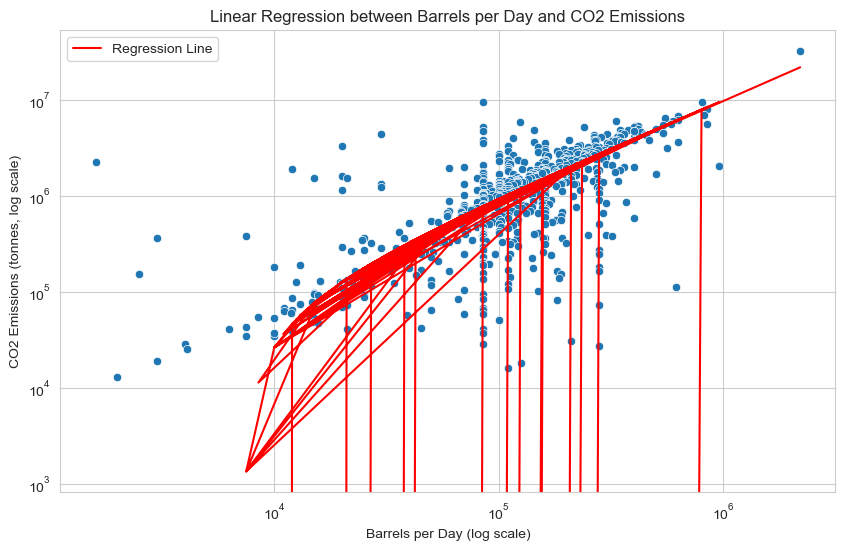

Regression Coefficient (Slope): 9.96
Regression Intercept: -73389.62


In [663]:
# Extract the relevant columns
data = oil_ref_df[['Barrels per Day', 'CO2 Emissions (tonnes)']].dropna()

# Scatter plot to visualize relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Barrels per Day', y='CO2 Emissions (tonnes)', data=data)
plt.title('Relationship between Barrels per Day and CO2 Emissions')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Barrels per Day (log scale)')
plt.ylabel('CO2 Emissions (tonnes, log scale)')
plt.show()

# Correlation between Barrels per Day and CO2 Emissions
correlation, p_value = pearsonr(data['Barrels per Day'], data['CO2 Emissions (tonnes)'])
print(f'Pearson Correlation: {correlation:.2f}')
print(f'P-value: {p_value:.2e}')

# Linear Regression Model
X = data[['Barrels per Day']].values
y = data['CO2 Emissions (tonnes)'].values
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)

# Add regression line to the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Barrels per Day', y='CO2 Emissions (tonnes)', data=data)
plt.plot(data['Barrels per Day'], predictions, color='red', label='Regression Line')
plt.xscale('log')
plt.yscale('log')
plt.title('Linear Regression between Barrels per Day and CO2 Emissions')
plt.xlabel('Barrels per Day (log scale)')
plt.ylabel('CO2 Emissions (tonnes, log scale)')
plt.legend()
plt.show()

# Print the regression coefficients
print(f'Regression Coefficient (Slope): {model.coef_[0]:.2f}')
print(f'Regression Intercept: {model.intercept_:.2f}')

Mean bbl/p: 154010.05979073243
Standard Deviation of bbl/p: 148215.909176927


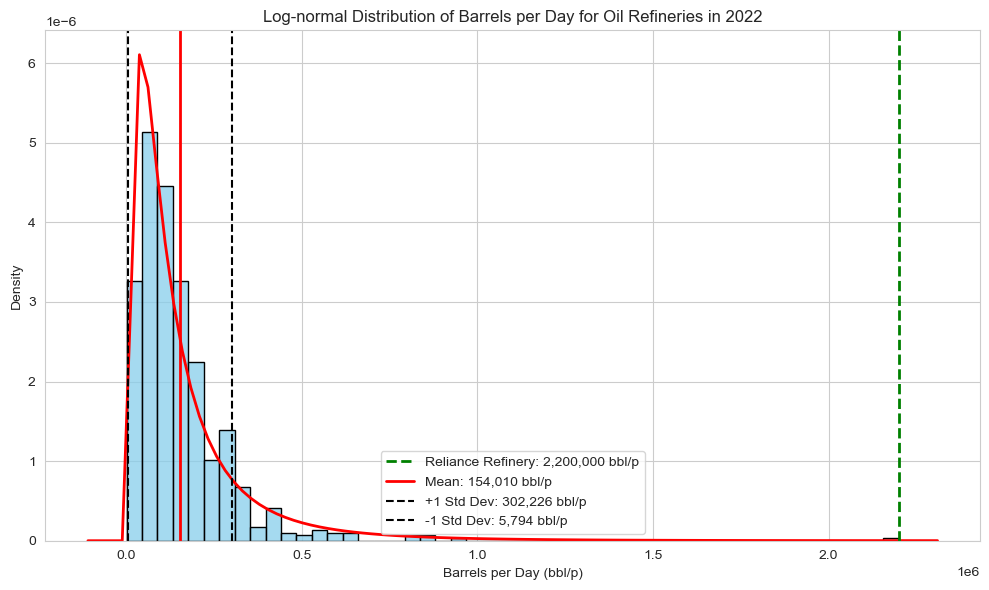

In [664]:
# Extract the CO2 Emissions column
co2_emissions = oil_ref_df['Barrels per Day']

# Filter out zero or negative values to avoid issues with log scaling
co2_emissions = co2_emissions[co2_emissions > 0]

# Calculate mean and standard deviation
mean = co2_emissions.mean()
std_dev = co2_emissions.std()

print(f"Mean bbl/p: {mean}")
print(f"Standard Deviation of bbl/p: {std_dev}")

# CO2 Emissions for Reliance Refinery (replace with the actual value or row from the DataFrame)
reliance_co2_emissions = oil_ref_df[oil_ref_df['Name'] == 'RPL (Reliance Petroleum Limited) Jamnagar Refinery']['Barrels per Day'].values[0]

# Plotting the normal distribution
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

# Plot histogram of the data with density normalization
sns.histplot(co2_emissions, bins=50, kde=False, stat='density', color='skyblue', edgecolor='black')

# Plot the log-normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
log_shape, log_loc, log_scale = lognorm.fit(co2_emissions, floc=0)
p = lognorm.pdf(x, log_shape, log_loc, log_scale)
plt.plot(x, p, 'r', linewidth=2)


# Add a vertical line where the Reliance Refinery lies
plt.axvline(reliance_co2_emissions, color='green', linestyle='--', linewidth=2, label=f'Reliance Refinery: {reliance_co2_emissions:,.0f} bbl/p')

# Add a red vertical line for the mean
plt.axvline(mean, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean:,.0f} bbl/p')

# Add black vertical lines for standard deviation
plt.axvline(mean + std_dev, color='black', linestyle='--', linewidth=1.5, label=f'+1 Std Dev: {mean + std_dev:,.0f} bbl/p')
plt.axvline(mean - std_dev, color='black', linestyle='--', linewidth=1.5, label=f'-1 Std Dev: {mean - std_dev:,.0f} bbl/p')

# Add labels and title
plt.title('Log-normal Distribution of Barrels per Day for Oil Refineries in 2022')
plt.xlabel('Barrels per Day (bbl/p)')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

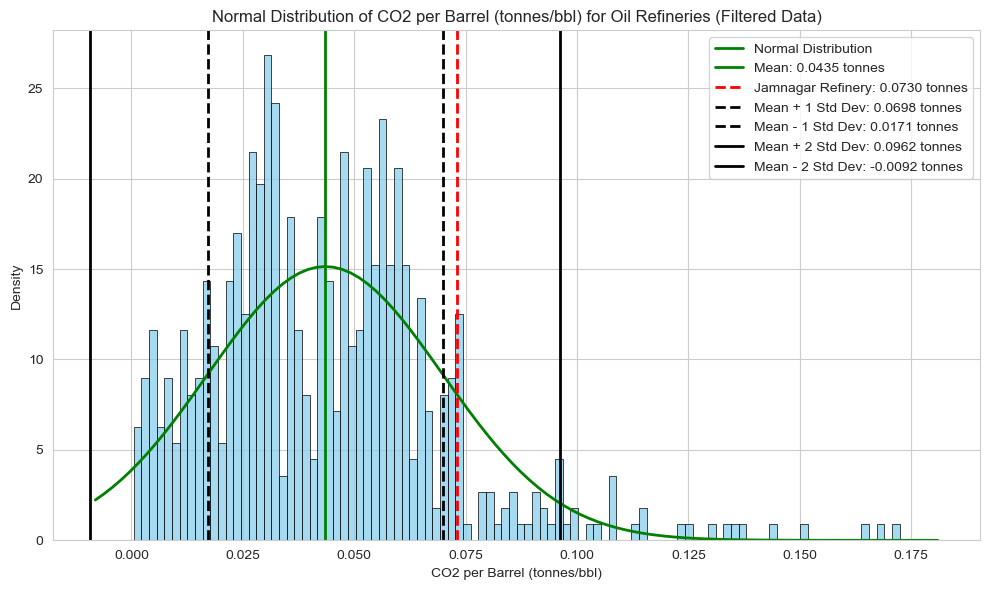

In [665]:
# Filter the data to exclude entries where Pollution_per_barrel is higher than 0.2 tonnes
filtered_df = oil_ref_df[oil_ref_df['Pollution_per_barrel'] <= 0.2]

# Calculate the mean and standard deviation of Pollution_per_barrel from the filtered data (in tonnes)
mean_co2_per_bbl = filtered_df['Pollution_per_barrel'].mean()
std_dev_co2_per_bbl = filtered_df['Pollution_per_barrel'].std()

# Find the Pollution_per_barrel for 'RPL (Reliance Petroleum Limited) Jamnagar Refinery' from the filtered data
reliance_co2_per_bbl = filtered_df[filtered_df['Name'] == 'RPL (Reliance Petroleum Limited) Jamnagar Refinery']['Pollution_per_barrel'].values[0]

# Plot the normal distribution with the filtered data
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

# Plot histogram of Pollution_per_barrel with density normalization (in tonnes)
sns.histplot(filtered_df['Pollution_per_barrel'], bins=100, kde=False, stat='density', color='skyblue', edgecolor='black')

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_co2_per_bbl, std_dev_co2_per_bbl)
plt.plot(x, p, 'g', linewidth=2, label='Normal Distribution')

# Add a vertical line at the mean
plt.axvline(mean_co2_per_bbl, color='green', linestyle='-', linewidth=2, label=f'Mean: {mean_co2_per_bbl:.4f} tonnes')

# Add a vertical line for the Reliance Refinery (in tonnes)
plt.axvline(reliance_co2_per_bbl, color='red', linestyle='--', linewidth=2, label=f'Jamnagar Refinery: {reliance_co2_per_bbl:.4f} tonnes')

# Add a vertical line at mean + 1 standard deviation (upper bound, in tonnes)
plt.axvline(mean_co2_per_bbl + 1 * std_dev_co2_per_bbl, color='black', linestyle='--', linewidth=2, label=f'Mean + 1 Std Dev: {(mean_co2_per_bbl + 1 * std_dev_co2_per_bbl):.4f} tonnes')

# Add a vertical line at mean - 1 standard deviation (lower bound, in tonnes)
plt.axvline(mean_co2_per_bbl - 1 * std_dev_co2_per_bbl, color='black', linestyle='--', linewidth=2, label=f'Mean - 1 Std Dev: {(mean_co2_per_bbl - 1 * std_dev_co2_per_bbl):.4f} tonnes')

# Add a vertical line at mean + 2 standard deviations (upper bound, in tonnes)
plt.axvline(mean_co2_per_bbl + 2 * std_dev_co2_per_bbl, color='black', linestyle='-', linewidth=2, label=f'Mean + 2 Std Dev: {(mean_co2_per_bbl + 2 * std_dev_co2_per_bbl):.4f} tonnes')

# Add a vertical line at mean - 2 standard deviations (lower bound, in tonnes)
plt.axvline(mean_co2_per_bbl - 2 * std_dev_co2_per_bbl, color='black', linestyle='-', linewidth=2, label=f'Mean - 2 Std Dev: {(mean_co2_per_bbl - 2 * std_dev_co2_per_bbl):.4f} tonnes')

# Add labels and title
plt.title('Normal Distribution of CO2 per Barrel (tonnes/bbl) for Oil Refineries (Filtered Data)')
plt.xlabel('CO2 per Barrel (tonnes/bbl)')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
